# Polygenic Risk Score Analysis on Height GWAS data

Here we show an example of our [LDpred2 pipeline](https://github.com/cumc/bioworkflows/blob/master/ldpred/ldpred.ipynb) for height PRS on [an example public data-set](https://drive.google.com/file/d/1x_G0Gxk9jFMY-PMqwtg6-vdEyUPp5p5u/view) from github user [@choishingwan](https://github.com/choishingwan).

Analysis in this tutorial is performed by running our pipeline sequentially on a single computer (a desktop, laptop, or a single interactive node on a cluster). The pipeline iteself, implemented in the SoS workflow language, can be configured to run in parallel on a high performance computing cluster environment. Please read the [SoS documentation](https://vatlab.github.io/sos-docs/doc/user_guide/host_setup.html) on how to configure the software and workflow to efficiently perform the analysis for real-world data.

## Data used

### Reference panel

Obtained via `download_1000G()` in `bigsnpr`. 

We extracted unrelated European individuals (~500  samples) and ~1.7M SNPs in common with either HapMap3 or the UK Biobank. Classification of European population can be found at [IGSR](https://www.internationalgenome.org/category/population/). European individuals ID are from [IGSR data portal](https://www.internationalgenome.org/data-portal/sample).

### GWAS summary statistics data

`Height.QC.gz`, from public data-set provided by github user [@choishingwan](https://github.com/choishingwan), of height GWAS in European samples.

### Target test data

`EUR.height`, `EUR.cov`, and `EUR.eigenvec` contain phenotypes, covariates and genotype principle components of samples. `EUR.QC.*` contain the corresponding genotypes, with ~400,000 variants. We have thinned the genotype data to ~150,000 variants for speeding up the examples used in this tutorial. The resulting genotypes are in `EUR_prune.*`.

## PRS Models applied

Auto model runs the algorithm for 30 different $p$ (the proportion of causal variants) values range from 10e-4 to 0.9, and heritability $h^2$ from LD score regression as initial value.

Grid model tries a grid of parameters $p$, ranges from 0 to 1 and three $h^2$ which are 0.7/1/1.4 times of initial $h^2$ estimated by LD score regression.

## Data preparation

Please download the [tutorial data](http://statgen.us/files/2021/01/ldpred2.tar.gz) and [pipeline script](https://github.com/cumc/bioworkflows/blob/master/ldpred/ldpred.ipynb) to your computer. We have pre-downloaded and extracted the European genotypes from 1000 Genomes. We have preprocessed the GWAS data as follows, to fit in our pipeline.

**Please do not run any code from this section. The data bundle above contains all the preprocessed files for you to start the PRS analysis (next section). Code below are documented here for book-keeping and reproducibility.**

In [2]:
%cd ~/tmp/25-Oct-2021

/home/gw/tmp/25-Oct-2021

### Summary statistics formatting

In [2]:
sumstats <- bigreadr::fread2("GWAS_data/Height.QC.gz") 
# LDpred2 require the header to follow the exact naming
names(sumstats) <-
    c("chr",
    "pos",
    "rsid",
    "a1",
    "a0",
    "n_eff",
    "beta_se",
    "p",
    "OR",
    "INFO",
    "MAF")
# Transform the OR into log(OR)
sumstats$beta <- log(sumstats$OR)

In [3]:
saveRDS(sumstats, "GWAS_data/Height.QC.rds")

### Phenotype and covariates formatting

In [35]:
options(stringsAsFactors=F)
fam = read.table("GWAS_data/EUR_prune.fam", header=F)
colnames(fam) = c("FID", "IID", "PID", "MID", "S", "D")
pheno = read.table("GWAS_data/EUR.height", header=T)
covar = read.table("GWAS_data/EUR.cov", header=T)
pcs = read.table("GWAS_data/EUR.eigenvec", header=F)
colnames(pcs) = c("FID", "IID", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6")

In [36]:
require(dplyr)
pheno_out = left_join(fam, pheno, by = c("FID", "IID"))
pheno_out = left_join(pheno_out, covar, by = c("FID", "IID"))
pheno_out = left_join(pheno_out, pcs, by = c("FID", "IID"))

In [44]:
write.table(pheno_out[, "Height"], "GWAS_data/EUR.height.matched.txt", col.names="Height",row.names=F)
write.table(pheno_out[, c("Sex",'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6')], "GWAS_data/EUR.cov.matched.txt", col.names=T,row.names=F)

The directory should have the following:

In [4]:
tree

.
├── 1000G.EUR
│   ├── 1000G.EUR.bed
│   ├── 1000G.EUR.bim
│   └── 1000G.EUR.fam
├── GWAS_data
│   ├── EUR.cov
│   ├── EUR.eigenvec
│   ├── EUR.height
│   ├── EUR_prune.bed
│   ├── EUR_prune.bim
│   ├── EUR_prune.fam
│   ├── Height.QC.gz
│   └── Height.QC.rds
└── ldpred.ipynb

2 directories, 17 files


## Analysis of height GWAS data

We set the work directory to `height_results` folder (to be created by the workflow). This will also be used as part of the filenames in the outputs to identify this analysis.

In [4]:
work_dir="height_results"

### Step 1: QC on reference panel

Here we assume the GWAS genotype data `EUR.*` has already been QC-ed. We perform here QC for reference panel,

In [6]:
sos run ldpred.ipynb snp_qc \
    --cwd $work_dir \
    --genoFiles 1000G.EUR/1000G.EUR.bed

INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /home/gw/tmp/25-Oct-2021/height_results/1000G.EUR.height_results.bed
INFO: Workflow snp_qc (ID=w015cfd3cc381496b) is executed successfully with 1 completed step.


### Step 2: Intersect SNPs among summary stats, reference panel and target data

SNPs shared between summary statistics, reference panels and target genotype data (for which PRS will be computed) are extracted. 

In [7]:
sos run ldpred.ipynb snp_intersect \
    --cwd $work_dir \
    --ss GWAS_data/Height.QC.rds \
    --genoFiles $work_dir/1000G.EUR.$work_dir.bed GWAS_data/EUR_prune.bed

INFO: Running snp_intersect_1: SNP intersect of summary stats and genotype data
INFO: snp_intersect_1 is completed.
INFO: snp_intersect_1 output:   /home/gw/tmp/25-Oct-2021/height_results/Height.QC.intersect.rds /home/gw/tmp/25-Oct-2021/height_results/Height.QC.intersect.snplist
INFO: Running snp_intersect_2: 
INFO: snp_intersect_2 is completed (pending nested workflow).
INFO: Running preprocess_1: Filter SNPs and select individuals
INFO: preprocess_1 (index=1) is completed.
INFO: preprocess_1 (index=0) is completed.
INFO: preprocess_1 output:   /home/gw/tmp/25-Oct-2021/height_results/1000G.EUR.height_results.snp_intersect.extracted.bed /home/gw/tmp/25-Oct-2021/height_results/EUR_prune.snp_intersect.extracted.bed in 2 groups
INFO: Running convert PLNIK to bigsnpr format with missing data mean imputed: 
INFO: convert PLNIK to bigsnpr format with missing data mean imputed (index=0) is completed.
INFO: convert PLNIK to bigsnpr format with missing data mean imputed (index=1) is completed.


In [8]:
cat $work_dir/Height.QC.intersect.stdout

[1] "There are 109963 shared SNPs."


### Step 3: Harmonize alleles for shared SNPs

To handle major/minor allele, strand flips and consequently possible flips in sign for summary statistics.

In [9]:
sos run ldpred.ipynb snp_match \
    --cwd $work_dir \
    --reference_geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds \
    --ss GWAS_data/Height.QC.rds

INFO: Running snp_match: 
INFO: snp_match is completed.
INFO: snp_match output:   /home/gw/tmp/25-Oct-2021/height_results/Height.QC.snp_matched.rds /home/gw/tmp/25-Oct-2021/height_results/Height.QC.snp_matched.snplist
INFO: Workflow snp_match (ID=waa8f5f3cb5665126) is executed successfully with 1 completed step.


### Step 4: Summary statistics quality control (optional)

Please refer to documentation in the pipeline notebook [`ldpred.ipynb`](https://github.com/cumc/bioworkflows/blob/master/ldpred/ldpred.ipynb) for an explanation of summary statistics QC.

In [10]:
sos run ldpred.ipynb sumstats_qc \
    --cwd $work_dir \
    --reference_geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds \
    --ss $work_dir/Height.QC.snp_matched.rds \
    --sdy 1

INFO: Running sumstats_qc: 
INFO: sumstats_qc is completed.
INFO: sumstats_qc output:   /home/gw/tmp/25-Oct-2021/height_results/Height.QC.snp_matched.qc.png /home/gw/tmp/25-Oct-2021/height_results/Height.QC.snp_matched.qc.snplist... (3 items)
INFO: Workflow sumstats_qc (ID=wdbbf3e7458e2f8a0) is executed successfully with 1 completed step.


> height_results/Height.QC.snp_matched.qc.png (64.4 KiB):

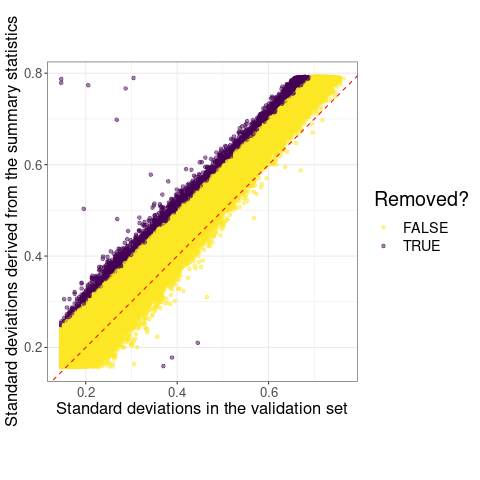

In [11]:
%preview height_results/Height.QC.snp_matched.qc.png

From the results, we observe only a few outliers significantly deviating from the majority of the variants. We suspect that quality control recommanded in [LDpred2 manuscript](https://academic.oup.com/bioinformatics/article/36/22-23/5424/6039173) may be too stringent and should not be needed for this data-set. Notice that as the manuscript pointed out, the quality control procedure is not suitable for meta-analyzed GWAS summary statistics.

### Step 5: Calculate LD matrix and fit LDSC model

As an illustration, hereafter all analysis are performed on both summary statistics before and after QC in Step 4.

In [12]:
sos run ldpred.ipynb ldsc \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.rds \
    --reference-geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds

INFO: Running ldsc: 
INFO: ldsc is completed.
INFO: ldsc output:   /home/gw/tmp/25-Oct-2021/height_results/Height.QC.snp_matched.ld.rds
INFO: Workflow ldsc (ID=we9a3f5af1a3a1a9c) is executed successfully with 1 completed step.


In [13]:
sos run ldpred.ipynb ldsc \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.qc.rds \
    --reference-geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds

INFO: Running ldsc: 
INFO: ldsc is completed.
INFO: ldsc output:   /home/gw/tmp/25-Oct-2021/height_results/Height.QC.snp_matched.qc.ld.rds
INFO: Workflow ldsc (ID=wbacc9e382c830fa4) is executed successfully with 1 completed step.


### Step 6: Estimate posterior effect sizes and PRS

For QC-ed data, we perform 3 PRS models implemented in `ldpred2`. We demonstrate the infinitesimal model here:

In [14]:
sos run ldpred.ipynb inf_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.qc.rds \
    --target-geno $work_dir/EUR_prune.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.qc.ld.rds

INFO: Running inf_prs: 
INFO: inf_prs is completed (pending nested workflow).
INFO: Running prs_core: 
INFO: prs_core is completed.
INFO: prs_core output:   /home/gw/tmp/25-Oct-2021/height_results/Height.QC.snp_matched.qc.inf_prs.rds
INFO: inf_prs output:   /home/gw/tmp/25-Oct-2021/height_results/Height.QC.snp_matched.qc.inf_prs.rds
INFO: Workflow inf_prs (ID=w1219f13000c52cc3) is executed successfully with 2 completed steps.


In [15]:
cat $work_dir/Height.QC.snp_matched.qc.inf_prs.stdout

[1] "104564 SNPs are used for PRS calculations"


Commands below will execute the "auto" model and "grid" model implemented in `LDpred2`. They are typically more powerful but also computationally intensive. We document them here without executing:

```
sos run ldpred.ipynb auto_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.qc.rds \
    --target-geno $work_dir/EUR_prune.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.qc.ld.rds
```

```
sos run ldpred.ipynb grid_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.qc.rds \
    --target-geno $work_dir/EUR_prune.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.qc.ld.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous
```

We then run the infinitesimal model for original data:

In [5]:
sos run ldpred.ipynb inf_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.rds \
    --target-geno $work_dir/EUR_prune.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.ld.rds

INFO: Running inf_prs: 
INFO: inf_prs is completed (pending nested workflow).
INFO: Running prs_core: 
INFO: prs_core is completed.
INFO: prs_core output:   /home/gw/tmp/25-Oct-2021/height_results/Height.QC.snp_matched.inf_prs.rds
INFO: inf_prs output:   /home/gw/tmp/25-Oct-2021/height_results/Height.QC.snp_matched.inf_prs.rds
INFO: Workflow inf_prs (ID=wf266994e074ae431) is executed successfully with 2 completed steps.


In [6]:
cat $work_dir/Height.QC.snp_matched.inf_prs.stdout

[1] "109963 SNPs are used for PRS calculations"


Again, here are commands for "auto" and "grid" models:

```
sos run ldpred.ipynb auto_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.rds \
    --target-geno $work_dir/EUR_prune.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.ld.rds
```

```
sos run ldpred.ipynb grid_prs \
    --cwd $work_dir \
    --ss $work_dir/Height.QC.snp_matched.rds \
    --target-geno $work_dir/EUR_prune.snp_intersect.extracted.rds \
    --ldsc $work_dir/Height.QC.snp_matched.ld.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous
```

**For `grid` model, in practice we should use another subset of individuals to train the model, independent from the subset to make PRS predictions. Here we use the same target genotype data only to illustrate the workflow.**

### Step 7: predict phenotypes

Baseline model: Trait ~ Sex + PCs

In [7]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/25-Oct-2021/height_results/EUR.height.matched.baseline.rds
INFO: Workflow pred_eval (ID=wbd7c33f977855a7a) is executed successfully with 1 completed step.


In [8]:
res = readRDS("height_results/EUR.height.matched.baseline.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.88058 -0.57445 -0.02782  0.51809  2.60256 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 168.78869    0.13623 1238.982   <2e-16 ***
Sex           0.89443    0.08528   10.488   <2e-16 ***
PC1          -0.99439    0.90011   -1.105   0.2700    
PC2          -2.36803    0.94434   -2.508   0.0126 *  
PC3          -0.67896    0.95222   -0.713   0.4763    
PC4           0.11199    1.72585    0.065   0.9483    
PC5           0.44029    0.95044    0.463   0.6435    
PC6           0.22226    0.91901    0.242   0.8090    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.82 on 367 degrees of freedom
  (11 observations deleted due to missingness)
Multiple R-squared:  0.244,	Adjusted R-squared:  0.2296 
F-statistic: 16.92 on 7 and 367 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model,0.22956,0.81868


Infinitesimal model: Trait ~ Sex + PCs + PRS

In [9]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/Height.QC.snp_matched.qc.inf_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/Height.QC.snp_matched.inf_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/25-Oct-2021/height_results/EUR.height.matched.Height.QC.snp_matched.qc.inf_prs.rds
INFO: Workflow pred_eval (ID=wd4028a7c469c4955) is executed successfully with 1 completed step.
INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/25-Oct-2021/height_results/EUR.height.matched.Height.QC.snp_matched.inf_prs.rds
INFO: Workflow pred_eval (ID=w4a11957219f352cc) is executed successfully with 1 completed step.


In [10]:
res = readRDS("height_results/EUR.height.matched.Height.QC.snp_matched.qc.inf_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.73022 -0.52593 -0.02819  0.47018  2.40831 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 168.33924    0.13482 1248.643   <2e-16 ***
Sex           0.86128    0.07794   11.050   <2e-16 ***
PC1          -1.02278    0.82162   -1.245    0.214    
PC2          -1.32032    0.87049   -1.517    0.130    
PC3          -1.23729    0.87159   -1.420    0.157    
PC4          -0.33061    1.57618   -0.210    0.834    
PC5           0.41503    0.86756    0.478    0.633    
PC6           0.06736    0.83906    0.080    0.936    
PRS           0.48895    0.05666    8.630   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7485 on 366 degrees of freedom
  (11 observations deleted due to missingness)
Multiple R-squared:  0.3718,	Adjusted R-squared:  0.3581 
F-statistic: 27.08 on 8 and 366 DF,  p-value: < 2.2e

model,R2,MSE
<chr>,<dbl>,<dbl>
model.inf_prs,0.35808,0.66951


In [11]:
res = readRDS("height_results/EUR.height.matched.Height.QC.snp_matched.inf_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.76996 -0.49580 -0.03413  0.48234  2.46181 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 168.31860    0.13505 1246.308   <2e-16 ***
Sex           0.85878    0.07772   11.049   <2e-16 ***
PC1          -1.13992    0.81936   -1.391   0.1650    
PC2          -1.43291    0.86602   -1.655   0.0989 .  
PC3          -1.25347    0.86909   -1.442   0.1501    
PC4          -0.30379    1.57142   -0.193   0.8468    
PC5           0.44159    0.86500    0.511   0.6100    
PC6           0.13108    0.83646    0.157   0.8756    
PRS           0.47989    0.05466    8.779   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7463 on 366 degrees of freedom
  (11 observations deleted due to missingness)
Multiple R-squared:  0.3755,	Adjusted R-squared:  0.3618 
F-statistic: 27.51 on 8 and 366 DF,  p-value: < 2.2e

model,R2,MSE
<chr>,<dbl>,<dbl>
model.inf_prs,0.36185,0.69411


Here are commands for running prediction with "auto" and "grid" models:

```
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/Height.QC.snp_matched.qc.auto_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/Height.QC.snp_matched.auto_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/Height.QC.snp_matched.qc.grid_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/Height.QC.snp_matched.grid_prs.rds \
    --phenoFile GWAS_data/EUR.height.matched.txt \
    --covFile GWAS_data/EUR.cov.matched.txt \
    --response continuous
```

## Results summary

Following table shows adjusted R squared of height prediction models. "QC" refers to quality control in Step 4.

Compared to baseline model, higher R squared with PRS included implies PRS explains part of the variation of height in the target data-set. Higher R squared is observed without performing quality control for the summary statistics, as we already expected and discussed after seeing the results in Step 4. 

| QC? |   # of SNPs  |   Baseline R2 |   Inf R2  |   Grid R2 |   Auto R2 |
|:---:|:------------:|:-------:|:-------:|:-------:|:-------:|
| Yes | 104,564 | 0.2296 | 0.3581 | -  | - |
|  No | 109,963 | 0.2296 | 0.3619 |    -  |    -   |

## Quiz

Please complete the runs with `grid` and `auto` model and complete the table. **Computation with these models are intensive and long-running; it is suggested that the analysis be performed in a powerful computing environment**.